In [1]:
import pandas as pd
import numpy as np 
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.signal import lfilter, butter, welch
from scipy.signal import find_peaks
import os
import glob

from tqdm import tqdm_notebook

In [2]:
path = r'Z:\Fedorov\Physiology\Fedorov-Lab\Skoltech Collaboration\test 04_04_2019'

In [3]:
for filename in glob.glob(os.path.join(path, '*.csv')):
    data = pd.read_csv(filename, header=0)
    print(filename, data.shape)

Z:\Fedorov\Physiology\Fedorov-Lab\Skoltech Collaboration\test 04_04_2019\H134_F83_FILTERED_BARD_HD.csv_annot.csv (16383, 192)


In [4]:
"""
Function performs bandpass filter for the digital signal 

Parameters: 
-----------
data: array_like
    An N-dimensional input array
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal
order: int
    The order of the filter.

Returns: 
-------
filtered_signal: array
    The output of the digital filter
"""

def butter_bandpass(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    
    high = highcut / nyq
    low = lowcut / nyq
    
    b, a = butter(order, [low, high], btype='bandpass', analog=False)
    filtered_signal = lfilter(b, a, data)
    
    return filtered_signal


"""
Fill NaN with zeros

Parameters: 
-----------
df: DataFrame
    DataFrame with NaNs
    
Returns: 
-------
df: Dataframe
    All NaNs filled by zeros
"""

def del_nul_and_nan(df):
    
    df.fillna(value=0, axis=1, inplace=True)    
    return df


"""


Parameters: 
-----------
df: pd.DataFrame
    An N-dimensional input DataFrame
N: int
    Number of sample points
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal

Returns: 
-------
fft_out: pd.DataFrame
    An output Dataframe with spectrum and frequencies 
"""

def spec_and_freq_for_single_df(df, N, fs, lowcut, highcut):
    
    fft_out = pd.DataFrame()
    
    for col in df.columns:
        filtered_yf = butter_bandpass(df[col], lowcut, highcut, fs, order=2)
        
        
        fft_yf = np.fft.fft(filtered_yf) #spectrum
        fft_xf = np.fft.fftfreq(N, 1/fs) #frequencies
        
        fft_20_index = np.argwhere((fft_xf<20) & (fft_xf>0))        
        fft_yf_20 = fft_yf[fft_20_index] #cutting on 20Hz
        fft_xf_20 = fft_xf[fft_20_index] #cutting on 20Hz
        
        fft_yf_20 = pd.DataFrame(np.abs(fft_yf_20) / N, columns=[col + '_yf'])
        fft_xf_20 = pd.DataFrame(fft_xf_20, columns=[col + '_xf']) 

        fft_out = pd.concat([fft_out, fft_yf_20, fft_xf_20], axis=1)
        
    return(fft_out)



"""

Parameters: 
-----------
class_data_list: list
    List with DataFrames 
    
Returns: 
-------
all_fft_el, all_fft_om: list, list
    Lists with spectrum and frequencies DataFrames
"""

def full_spec_and_freq(df):
    
    all_fft_el = pd.DataFrame()
    all_fft_om = pd.DataFrame()

    electrode_signal = df[df.columns[::3]]
    optical_signal = df[df.columns[2::3]]

    electrode_signal = del_nul_and_nan(electrode_signal)
    optical_signal = del_nul_and_nan(optical_signal)        

    N = df.shape[0] # Number of sample points
    Fs_el = 1017.25 # sampling rate
    Fs_om = 1000.0
         
    fft_el = spec_and_freq_for_single_df(electrode_signal, N, Fs_el, lowcut=1.5, highcut=20.0)
    fft_om = spec_and_freq_for_single_df(optical_signal, N, Fs_om, lowcut=1.5, highcut=20.0)
            
        
    all_fft_el = pd.concat([all_fft_el, fft_el], axis=1)
    all_fft_om = pd.concat([all_fft_om, fft_om], axis=1)
        
    return(all_fft_el, all_fft_om)



def max_peak_to_noise(df):
    y_col = [col for col in df.columns if '_yf' in col]
    y_df = df[y_col]
    snr = []
        
    for i in range(y_df.shape[1]):          
        s = y_df[y_col[i]][y_df[y_col[i]] != 0]

        _, properties = find_peaks(s, height=0)
        mean_max = np.mean(np.sort(properties['peak_heights'])[-2:])#np.max(properties['peak_heights'])
        sd = s.std(axis=0)
        ratio = np.round(mean_max / sd, 2)
        ratio = np.where(sd == 0, 0, ratio)
        snr.append(ratio)
        
    snr = pd.DataFrame(snr, columns=['SNR'], index=y_df.columns)
   
    return snr

In [5]:
MEM_spectrum,NIOM_spectrum = full_spec_and_freq(data)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [6]:
MEM_snr = max_peak_to_noise(MEM_spectrum)
MEM_snr_resized = np.resize(MEM_snr,(8,8)).transpose()
NIOM_snr = max_peak_to_noise(NIOM_spectrum)
NIOM_snr_resized = np.resize(NIOM_snr,(8,8)).transpose()

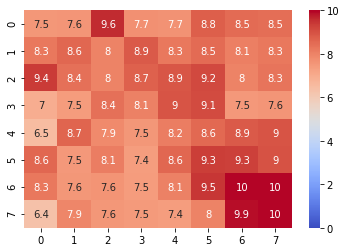

In [7]:
ax = sns.heatmap(MEM_snr_resized, vmin=0, vmax=10, annot=True,cmap="coolwarm")

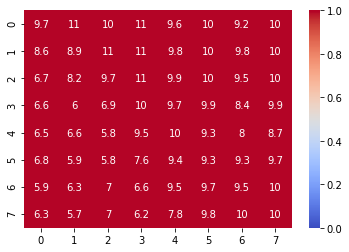

In [8]:
ax = sns.heatmap(NIOM_snr_resized, vmin=0, vmax=1, annot=True,cmap="coolwarm")